In [1]:
import numpy as np
import pandas as pd
from pandas import DataFrame
import matplotlib as mpl
import matplotlib.pyplot as plt
%matplotlib inline
import statsmodels.formula.api as smf
import warnings
warnings.filterwarnings('ignore')

In [2]:
#CrimeDataDayLevel
data = pd.read_csv('CrimeDataDayLevel.csv',parse_dates=['BeginDate'])

data['CrimeDate'] = data['BeginDate'].dt.date
data['Year'] = data['BeginDate'].dt.year
data.round(0)
print data['Year'].head() 
data['Year'] = data['Year'].astype('str')
data['Year-Month'] = pd.PeriodIndex(data['BeginDate'],freq='M') #to represent year-month of the crime
data['Weekday'] = data['BeginDate'].dt.weekday   # 0 is Monday
data['Month'] = data['BeginDate'].dt.month
data['Precinct'] = data['Precinct'].astype('str')

#categorizing offence types
segment_data = pd.read_csv('Segment_data.csv')
data = pd.merge(data, segment_data, on = "Offense")

#loading weekday names
week_data = pd.read_csv('Week_data.csv')
data = pd.merge(data,week_data, on = "Weekday")

#loading seasons of a year
season_data = pd.read_csv('Seasons_data.csv')
data = pd.merge(data,season_data, on = "Month")

#creating a dataset with data till 2015
data2 = data[data['Year'] != '2016']

0    2010
1    2010
2    2010
3    2010
4    2011
Name: Year, dtype: int64


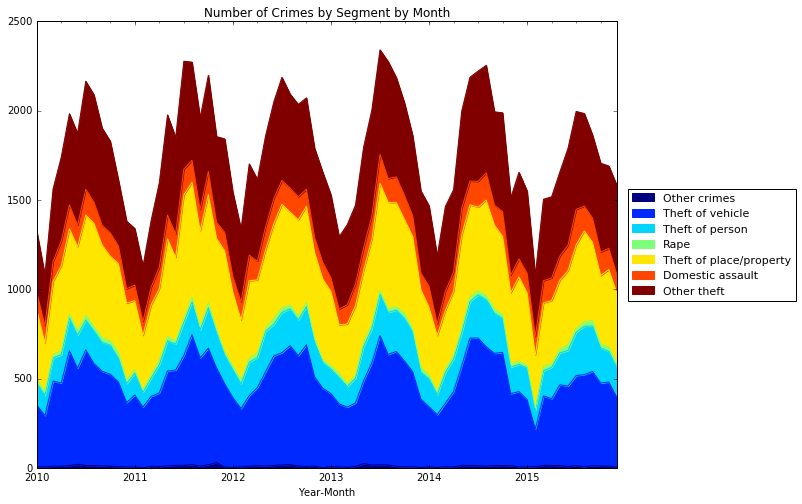

In [3]:
#Number of Crimes by Crime Type by Month -- AREA GRAPH

# Function to plot data grouped by Dates and Category
def plotTimeGroup(dfGroup, ncols=10, area=False, title=None):
    categoryCV = pd.DataFrame(columns=["Category", "CV"])
    rows = []

    for column in dfGroup.columns:
        col = dfGroup[column]
        # Only consider category, if there are enough samples
        if (col.sum() > 500):
            rows.append({'Category': column, 'CV': col.std() / col.mean()})

    categoryCV = pd.DataFrame(rows).sort_values(by="CV", ascending=0)
    #The graph with all categories is unreadable. Therefore, columns with a
    # high coefficient of variation are extracted:
    topCVCategories = categoryCV[:ncols]["Category"].tolist()
    plt.rcParams['figure.figsize'] = (30, 30)
    f = plt.figure(figsize=(13,8))
    ax = f.gca()
    if area:
        dfGroup[topCVCategories].plot.area(ax=ax, title=title, colormap="jet")
    else:
        dfGroup[topCVCategories].plot(ax=ax, title=title, colormap="jet")
    box = ax.get_position()
    ax.set_position([box.x0, box.y0, box.width * 0.8, box.height])
    plt.legend(loc='center left', bbox_to_anchor=(1, 0.5), borderaxespad=1, fontsize=11)
    
crimeBySegmentByMonth = data2.groupby(['Year-Month','Segment']).size().unstack()
plotTimeGroup(crimeBySegmentByMonth, title='Number of Crimes by Segment by Month', area=True)
plt.show()

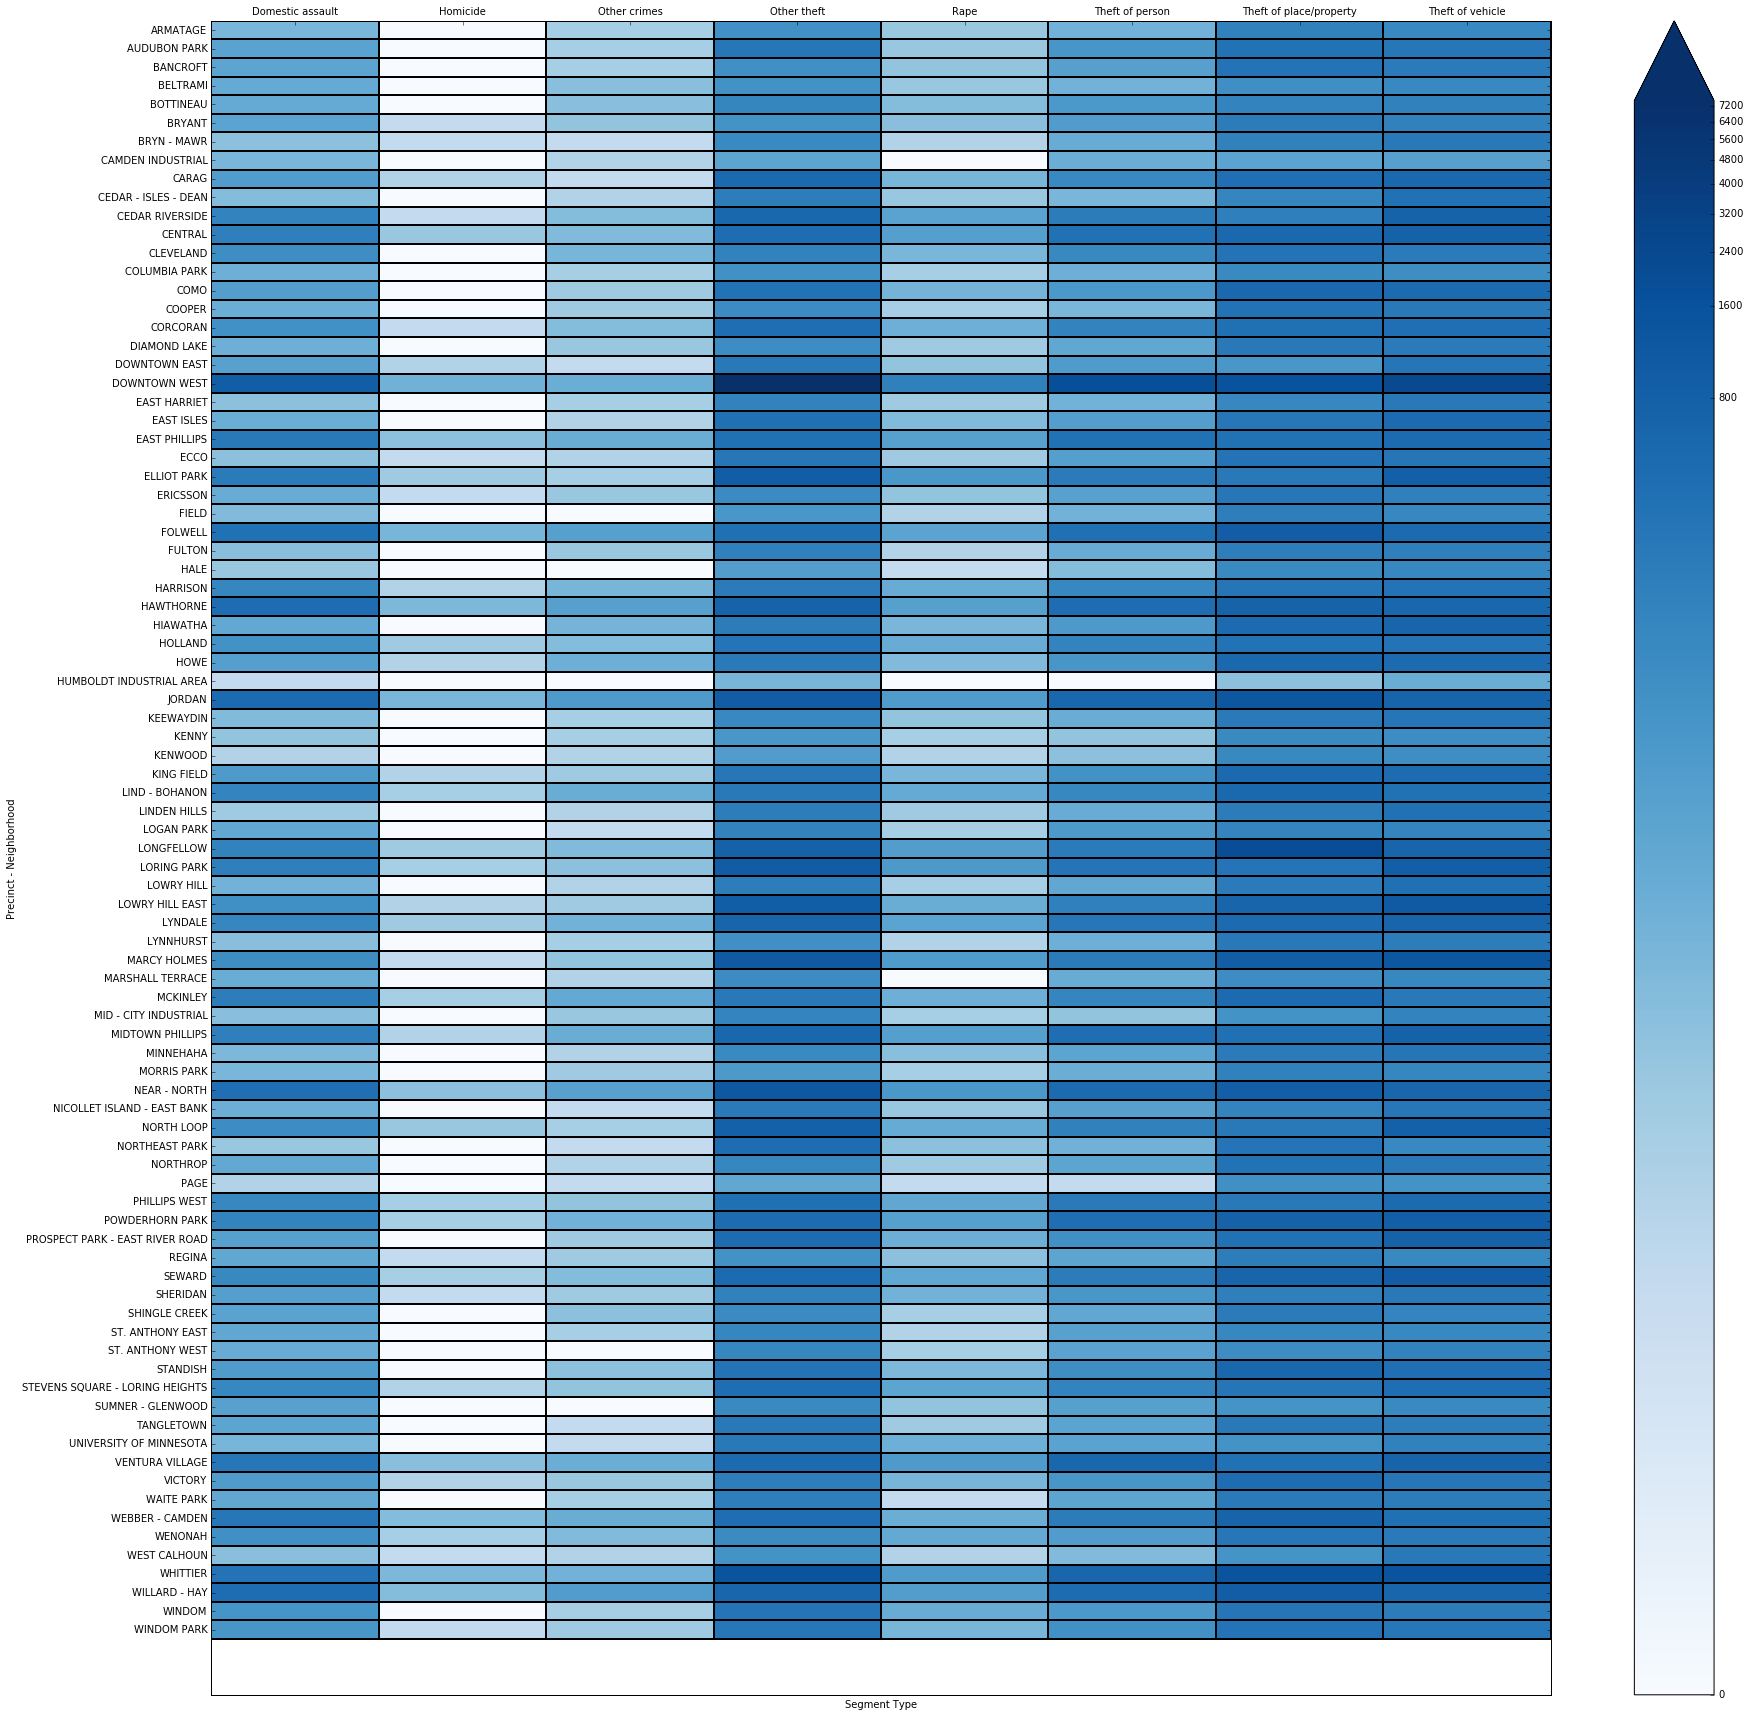

In [4]:
#Variation in Number of Crimes by Neighborhood by Crime Type  --- HEAT MAP

dataSegmentNeighborhoodCNN = data2[['Neighborhood','Segment','CCN','Year']]
crimeBySegmentByNeighborhood = dataSegmentNeighborhoodCNN.groupby(['Neighborhood','Segment']).size().unstack()
crimeBySegmentByNeighborhood = crimeBySegmentByNeighborhood.fillna(0)
column_labels =  crimeBySegmentByNeighborhood.index #Appear as rows in the plot
row_labels = crimeBySegmentByNeighborhood.columns

plt.rcParams['figure.figsize'] = (30, 30)
fig, ax = plt.subplots()
norm1= mpl.colors.SymLogNorm(linthresh=0.05, linscale=0.05,vmin=0.0, vmax=7500.0)
heatmap = ax.pcolormesh(crimeBySegmentByNeighborhood, cmap='Blues',alpha=1,edgecolors='k',norm=norm1) #RdBu_r #Reds
ax.set_xticks(np.arange(crimeBySegmentByNeighborhood.shape[1])+0.5, minor=False)
ax.set_yticks(np.arange(crimeBySegmentByNeighborhood.shape[0])+0.5, minor=False)
ax.invert_yaxis()
ax.xaxis.tick_top()
ax.set_xticklabels(row_labels, minor=False)
ax.set_yticklabels(column_labels, minor=False)
ax.set_ylabel('Precinct - Neighborhood')
ax.set_xlabel('Segment Type')
fig.colorbar(heatmap,extend='max')
fig.show()


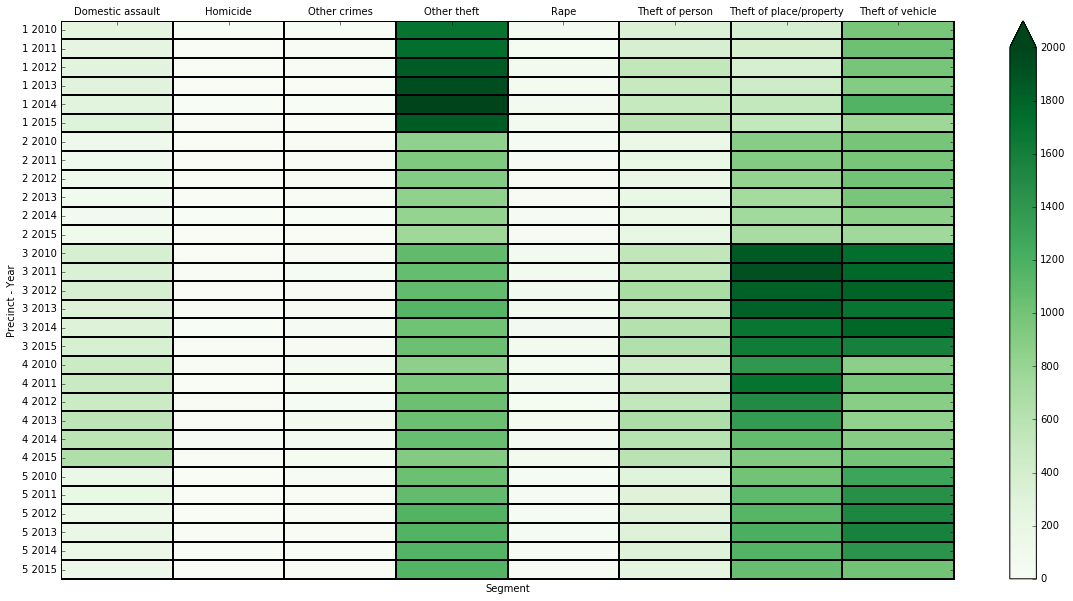

In [5]:
##Variation in Number of Crimes by Precinct and Crime Type  --- HEAT MAP
dataA = data2[['Year','Segment','CCN','Precinct']]

dataA['Precinct-Year'] = dataA['Precinct'].map(str) +' '+ dataA['Year']
crimeByPrecinctYearBySegment = dataA.groupby(['Precinct-Year','Segment']).size().unstack()
crimeByPrecinctYearBySegment = crimeByPrecinctYearBySegment.fillna(0)

column_labels =  crimeByPrecinctYearBySegment.index
row_labels = crimeByPrecinctYearBySegment.columns

plt.rcParams['figure.figsize'] = (20, 10)
fig, ax = plt.subplots()
norm2= mpl.colors.Normalize(vmin=0.0, vmax=2000.0)
heatmap = ax.pcolormesh(crimeByPrecinctYearBySegment, cmap='Greens',alpha=1,norm=norm2,edgecolors='k')

ax.set_xticks(np.arange(crimeByPrecinctYearBySegment.shape[1])+0.5, minor=False)
ax.set_yticks(np.arange(crimeByPrecinctYearBySegment.shape[0])+0.5, minor=False)

ax.invert_yaxis()
ax.xaxis.tick_top()
ax.set_ylabel('Precinct - Year')
ax.set_xlabel('Segment')
ax.set_xticklabels(row_labels, minor=False)
ax.set_yticklabels(column_labels,minor=False)
fig.colorbar(heatmap,extend='max')
fig.show()


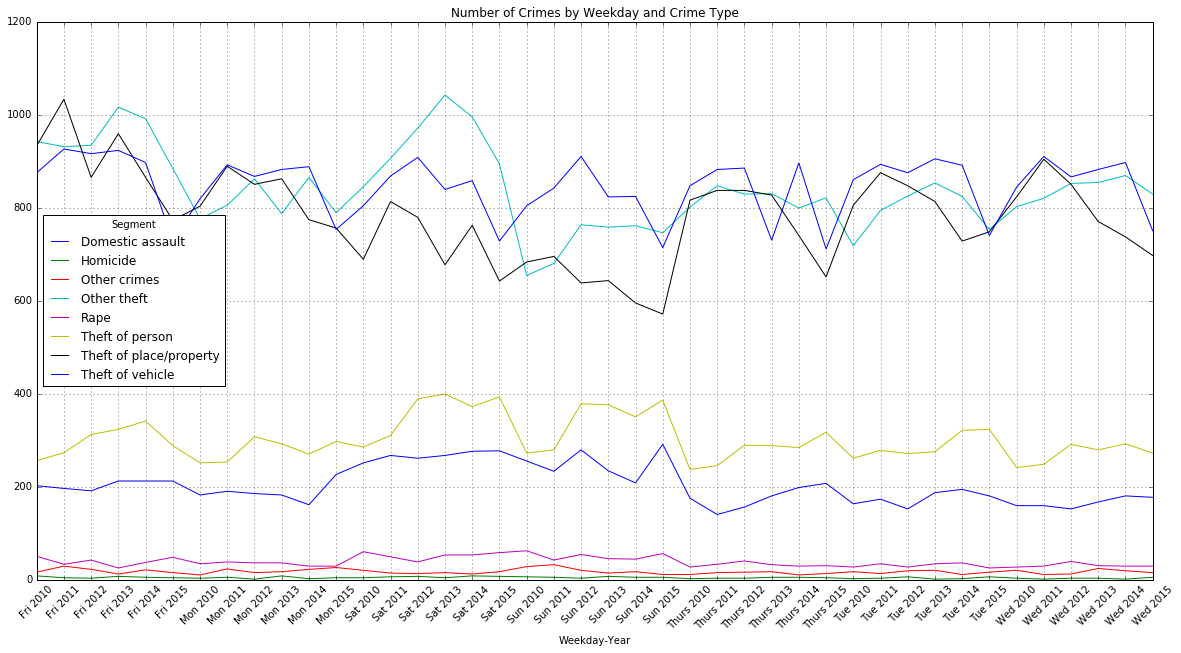

In [6]:
##Number of Crimes by Year by Weekday  -- LINE GRAPH
data2['Weekday-Year'] = data2.Wkday.str.cat(' '+data2.Year)
data2['Weekday-Year'] = data2['Weekday-Year'].astype('str')
crimeBySegmentByWeekday = data2.groupby(['Weekday-Year','Segment']).size().unstack()
crimeBySegmentByWeekday.plot(grid=True,title='Number of Crimes by Weekday and Crime Type')
plt.subplot()
ax.set_ylabel('Number of Crimes')
ax.set_xlabel('Weekday-Year')
xValues = crimeBySegmentByWeekday.index
plt.xticks( np.arange(42), xValues, rotation=45 )
plt.show()

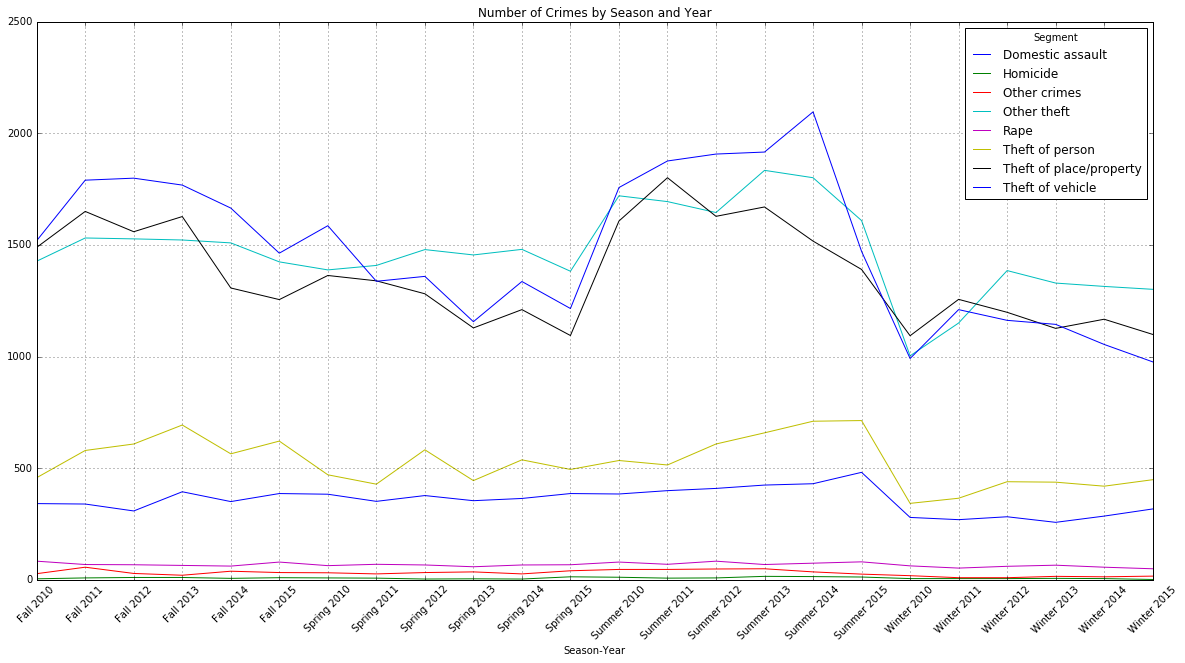

In [7]:
#Number of Crimes by Year by Weekday  -- LINE GRAPH

data2['Season-Year'] = data2.Season.str.cat(' '+data2.Year)
data2['Season-Year'] = data2['Season-Year'].astype('str')
crimeBySegmentBySeason = data2.groupby(['Season-Year','Segment']).size().unstack()
crimeBySegmentBySeason.plot(grid=True,title='Number of Crimes by Season and Year')
ax.set_ylabel('Number of Crimes')
ax.set_xlabel('Season-Year')
xValues = crimeBySegmentBySeason.index
plt.xticks( np.arange(24), xValues, rotation=45 )
plt.show()

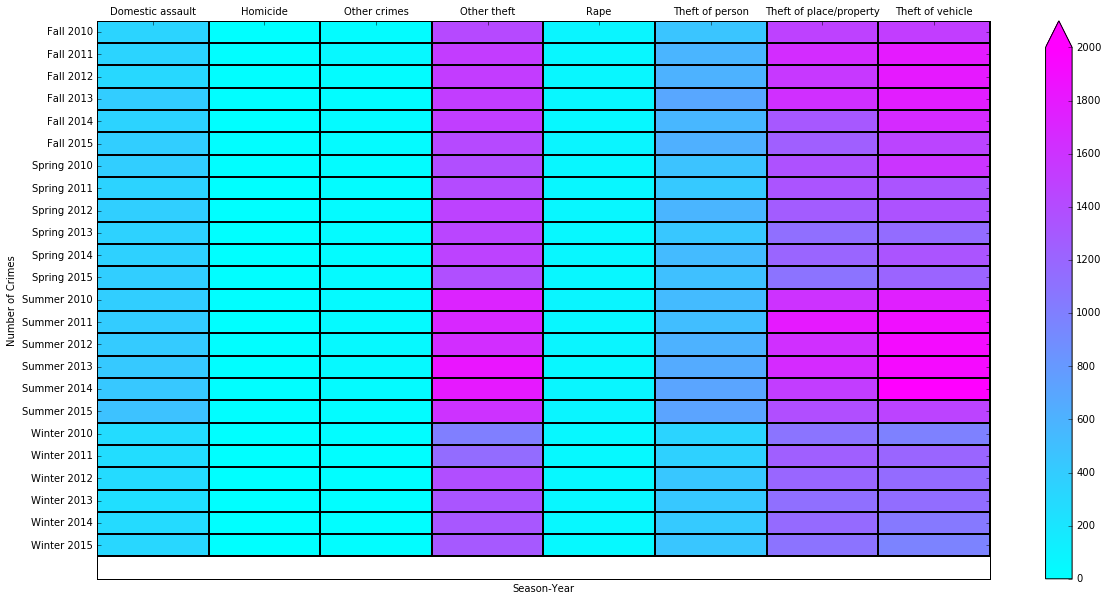

In [8]:
#Variation in number of Crimes by Season Year by CrimeType  -- HEAT MAP

dataSeasonYearSegment = data2[['Year','Segment','CCN','Season']]
dataSeasonYearSegment['Season-Year'] = dataSeasonYearSegment.Season.str.cat(' '+dataSeasonYearSegment.Year)
dataSeasonYearSegment = dataSeasonYearSegment.groupby(['Season-Year','Segment']).size().unstack()
dataSeasonYearSegment = dataSeasonYearSegment.fillna(0)

column_labels =  dataSeasonYearSegment.columns
row_labels = dataSeasonYearSegment.index

column_labels =  dataSeasonYearSegment.index#Appear as rows in the plot
row_labels = dataSeasonYearSegment.columns

fig, ax = plt.subplots()
norm2= mpl.colors.Normalize(vmin=0.0, vmax=2000.0)
heatmap = ax.pcolormesh(dataSeasonYearSegment, cmap='cool',alpha=1,norm=norm2,edgecolors='k')

ax.set_xticks(np.arange(dataSeasonYearSegment.shape[1])+0.5, minor=False)
ax.set_yticks(np.arange(dataSeasonYearSegment.shape[0])+0.5, minor=False)

ax.invert_yaxis()
ax.xaxis.tick_top()
ax.set_ylabel('Number of Crimes')
ax.set_xlabel('Season-Year')
ax.set_xticklabels(row_labels, minor=False)
ax.set_yticklabels(column_labels, minor=False)
fig.colorbar(heatmap,extend='max')
fig.show()


Find below the weightage associated with crime types for the Neighbourhood score :
Homicide - 0.2
Rape - 0.2
Domestic assault - 0.15
Theft of vehicle - 0.1
Theft of place/property - 0.1
Theft of person - 0.1
Other theft - 0.1
Other crimes - 0.05

Enter the weightages :
Enter weightage for Homicide (0.2) :0.3
Enter weightage for Rape (0.2) :0.4
Enter weightage for Domestic assault (0.15) :0.5
Enter weightage for Theft of vehicle (0.1) :0.6
Enter weightage for Theft of place/property (0.1) :0.7
Enter weightage for Theft of person (0.1) :0.5
Enter weightage for Other theft (0.1) :0.3
Enter weightage for Other crimes (0.05) :0.3
Segment                   NH_base_score
Neighborhood                           
HUMBOLDT INDUSTRIAL AREA       0.000183
CAMDEN INDUSTRIAL              0.001074
PAGE                           0.001299
HALE                           0.001833
KENWOOD                        0.001940
KENNY                          0.002302
MARSHALL TERRACE               0.002330
COLUMB

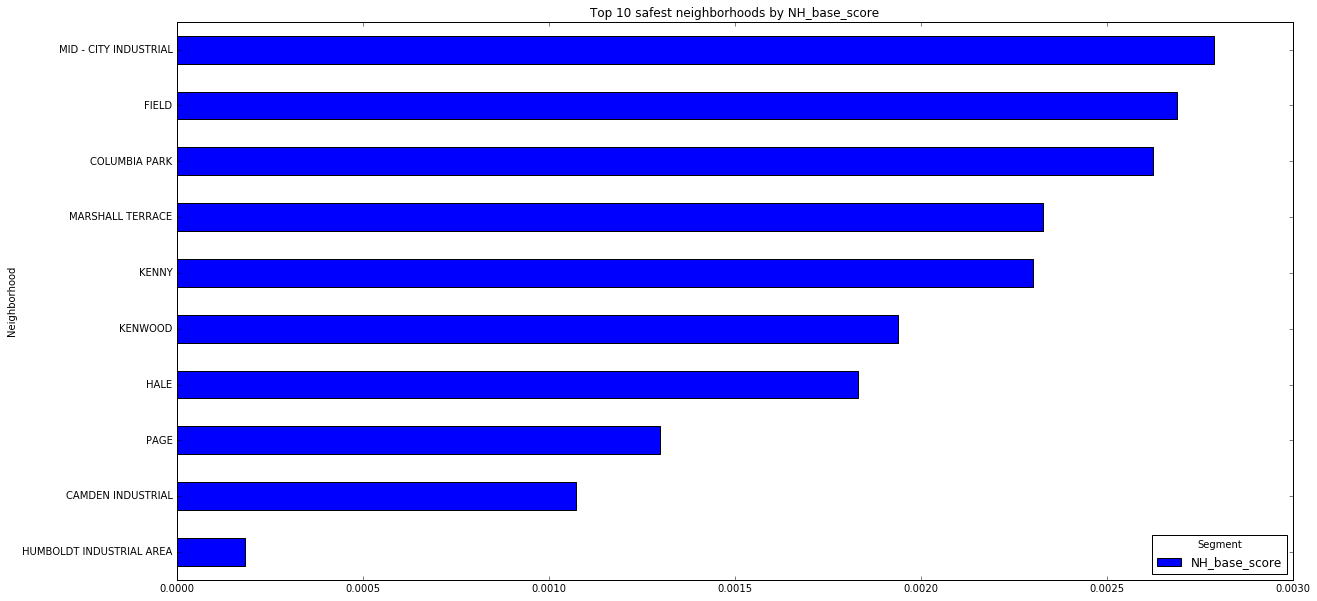

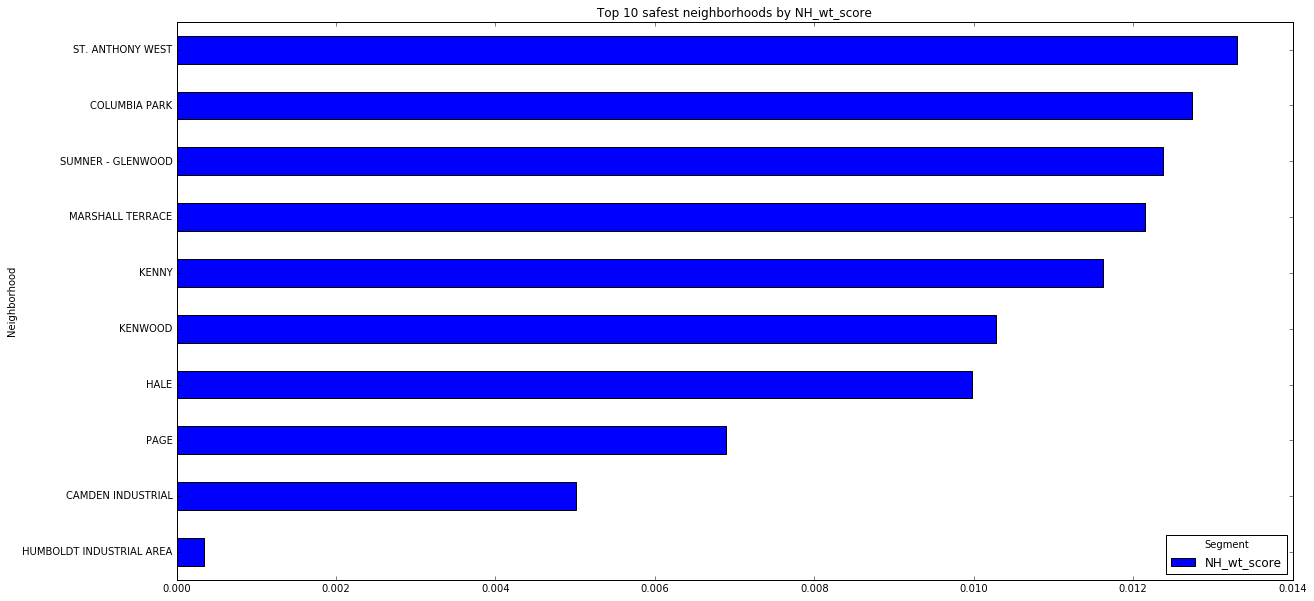

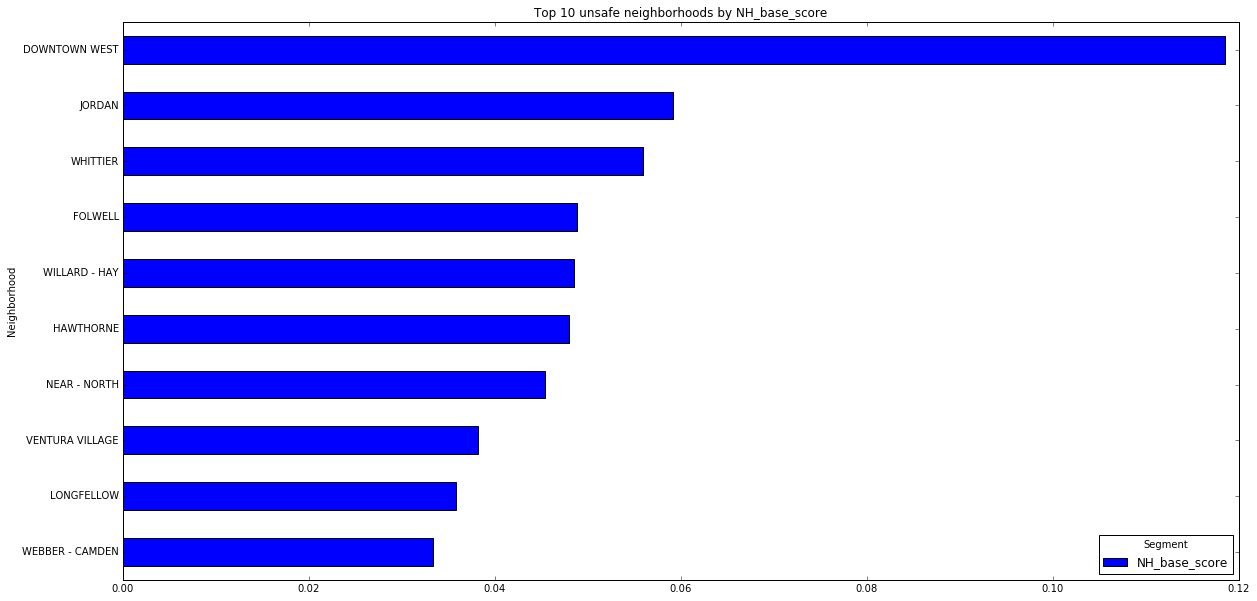

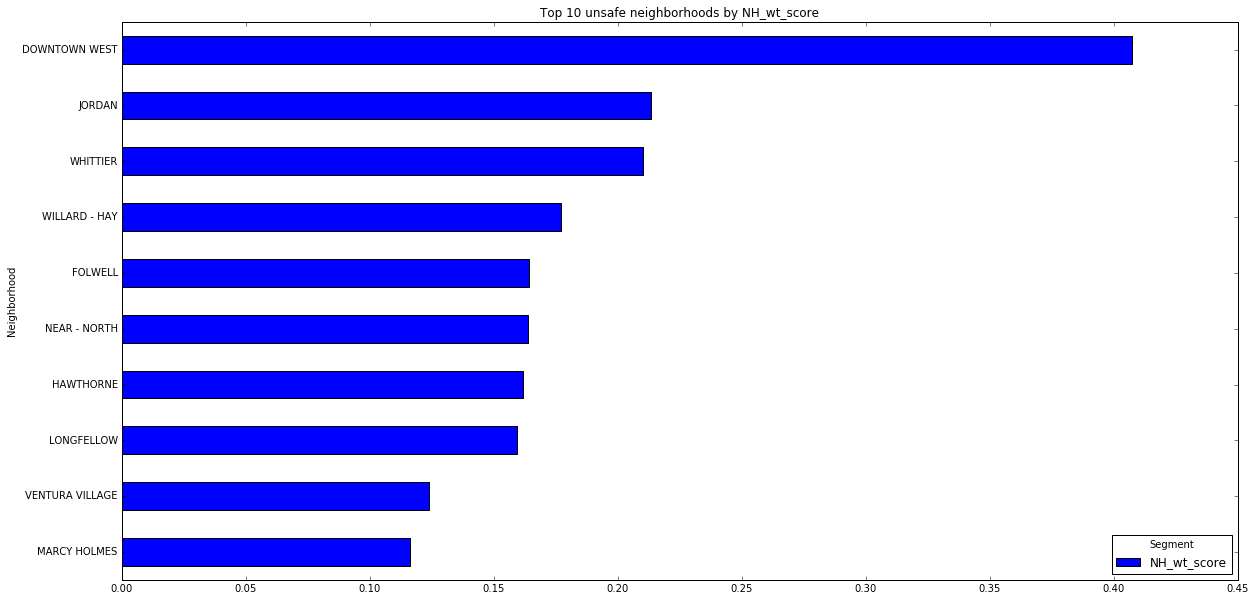

In [9]:
#Neighborhood Scoring 
#########################################################################################################################

print '\nFind below the weightage associated with crime types for the Neighbourhood score :'
print 'Homicide - 0.2'
print 'Rape - 0.2'
print 'Domestic assault - 0.15'
print 'Theft of vehicle - 0.1'
print 'Theft of place/property - 0.1'
print 'Theft of person - 0.1'
print 'Other theft - 0.1'
print 'Other crimes - 0.05'

print '\nEnter the weightages :'
homicide = float(raw_input('Enter weightage for Homicide (0.2) :' ))
rape = float(raw_input('Enter weightage for Rape (0.2) :' ))
dom_ass = float(raw_input('Enter weightage for Domestic assault (0.15) :' ))
theft_veh = float(raw_input('Enter weightage for Theft of vehicle (0.1) :' ))
theft_place = float(raw_input('Enter weightage for Theft of place/property (0.1) :' ))
theft_per = float(raw_input('Enter weightage for Theft of person (0.1) :' ))
other_theft = float(raw_input('Enter weightage for Other theft (0.1) :' ))
other_crime = float(raw_input('Enter weightage for Other crimes (0.05) :' ))

NHdata1 = data2[['Neighborhood','Segment','CCN']]
NHdata = NHdata1.groupby(['Neighborhood','Segment']).size().unstack()
NHdata = NHdata.fillna(0)

max_value = NHdata['Domestic assault'].max()
min_value = NHdata['Domestic assault'].min()
range_value = max_value - min_value
NHdata['Domestic assault'] = (NHdata['Domestic assault'] - min_value)/range_value

max_value = NHdata['Rape'].max()
min_value = NHdata['Rape'].min()
range_value = max_value - min_value
NHdata['Rape'] = (NHdata['Rape'] - min_value + 0.1)/range_value

max_value = NHdata['Homicide'].max()
min_value = NHdata['Homicide'].min()
range_value = max_value - min_value
NHdata['Homicide'] = (NHdata['Homicide'] - min_value + 0.1)/range_value

max_value = NHdata['Theft of vehicle'].max()
min_value = NHdata['Theft of vehicle'].min()
range_value = max_value - min_value
NHdata['Theft of vehicle'] = (NHdata['Theft of vehicle'] - min_value + 0.1)/range_value

max_value = NHdata['Theft of person'].max()
min_value = NHdata['Theft of person'].min()
range_value = max_value - min_value
NHdata['Theft of person'] = (NHdata['Theft of person'] - min_value + 0.1)/range_value

max_value = NHdata['Theft of place/property'].max()
min_value = NHdata['Theft of place/property'].min()
range_value = max_value - min_value
NHdata['Theft of place/property'] = (NHdata['Theft of place/property'] - min_value + 0.1)/range_value

max_value = NHdata['Other theft'].max()
min_value = NHdata['Other theft'].min()
range_value = max_value - min_value
NHdata['Other theft'] = (NHdata['Other theft'] - min_value + 0.1)/range_value

max_value = NHdata['Other crimes'].max()
min_value = NHdata['Other crimes'].min()
range_value = max_value - min_value
NHdata['Other crimes'] = (NHdata['Other crimes'] - min_value + 0.1)/range_value


NHdata['NH_base_score'] = (NHdata['Domestic assault'] * 0.15 +   NHdata['Rape'] * 0.2 +   NHdata['Homicide'] * 0.2 +   NHdata['Theft of vehicle'] * 0.1 +   NHdata['Theft of person'] * 0.1 +   NHdata['Theft of place/property'] * 0.1 +   NHdata['Other theft'] * 0.1 +   NHdata['Other crimes'] * 0.05)/8
NHdata['NH_wt_score'] = (NHdata['Domestic assault'] * dom_ass +   NHdata['Rape'] * rape +   NHdata['Homicide'] * homicide  +   NHdata['Theft of vehicle'] * theft_veh +   NHdata['Theft of person'] * theft_per  +   NHdata['Theft of place/property'] * theft_place +   NHdata['Other theft'] * other_theft +   NHdata['Other crimes'] * other_crime)/8

NHdataOriginalScore = NHdata[['NH_base_score']]
NHdataOriginalScore = NHdataOriginalScore.sort('NH_base_score').head(10)
print NHdataOriginalScore

NHdataWtScore = NHdata[['NH_wt_score']]
NHdataWtScore = NHdataWtScore.sort('NH_wt_score').head(10)
print NHdataWtScore

NHdataOriginalScore1 = NHdata[['NH_base_score']]
NHdataOriginalScore1 = NHdataOriginalScore1.sort('NH_base_score').tail(10)
print NHdataOriginalScore1

NHdataWtScore1 = NHdata[['NH_wt_score']]
NHdataWtScore1 = NHdataWtScore1.sort('NH_wt_score').tail(10)
print NHdataWtScore1

NHdataOriginalScore.plot(kind='barh', title = "Top 10 safest neighborhoods by NH_base_score")
NHdataWtScore.plot(kind='barh', title = "Top 10 safest neighborhoods by NH_wt_score")
NHdataOriginalScore1.plot(kind='barh', title = "Top 10 unsafe neighborhoods by NH_base_score") 
NHdataWtScore1.plot(kind='barh', title = "Top 10 unsafe neighborhoods by NH_wt_score") 
plt.show()

                            OLS Regression Results                            
Dep. Variable:          Actual_Crimes   R-squared:                       0.856
Model:                            OLS   Adj. R-squared:                  0.823
Method:                 Least Squares   F-statistic:                     26.29
Date:                Sun, 07 May 2017   Prob (F-statistic):           7.90e-21
Time:                        16:38:16   Log-Likelihood:                -404.60
No. Observations:                  77   AIC:                             839.2
Df Residuals:                      62   BIC:                             874.4
Df Model:                          14                                         
Covariance Type:            nonrobust                                         
                                coef    std err          t      P>|t|      [95.0% Conf. Int.]
---------------------------------------------------------------------------------------------
Intercept             

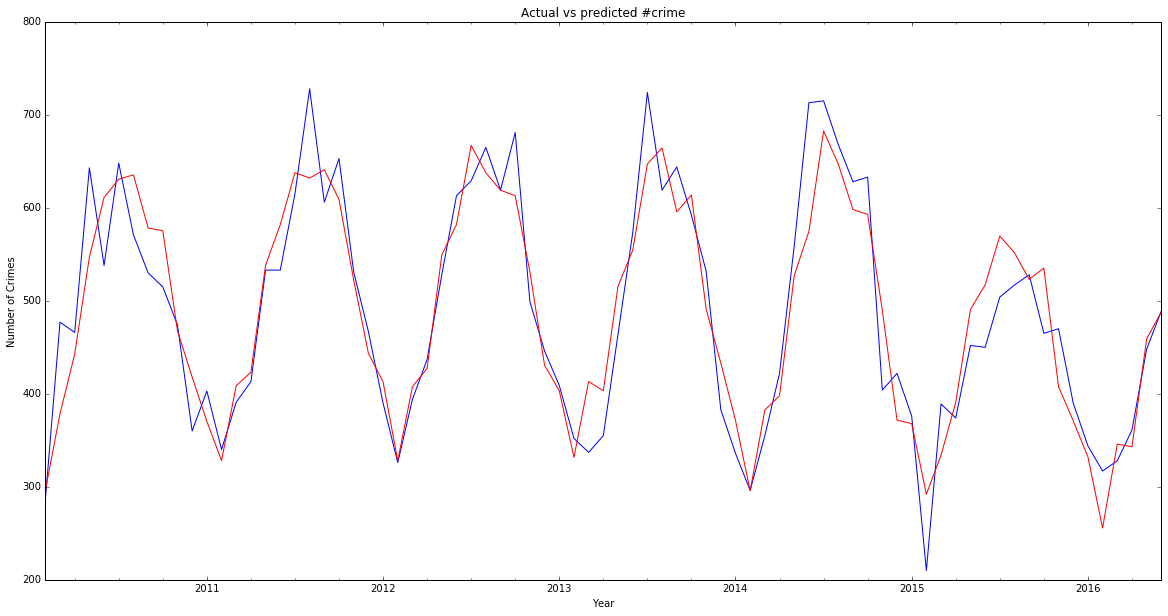

In [10]:
#predictive model
data1 = data[data['Segment'] == 'Theft of vehicle']
data1 = data1.groupby(['Year-Month']).size()
data1 = DataFrame(data1)
data1.reset_index(['Year-Month', 'crimes'], drop=False, inplace=True)
data1.columns = ['Year-Month','Actual_Crimes']
data1 = data1.set_index(['Year-Month'])
data1['Month'] = data1.index.month
data1['Trend'] = range(1, len(data1) + 1)
data1['Lag_1_Crimes'] = data1['Actual_Crimes'].shift(periods = 1)

data2 = data1[data1.Trend != 1]
data2['Month_cat'] = data2['Month'].astype("category")

#predictive model
mod = smf.ols("Actual_Crimes ~ Trend + np.multiply(Trend,Trend) + Month_cat + Lag_1_Crimes", data2).fit()
print(mod.summary())

data2['Actual_Crimes'].plot(kind='line')
fitted_values = mod.fittedvalues 
plt.plot(fitted_values, color='red')
plt.title('Actual vs predicted #crime')
plt.ylabel('Number of Crimes')
plt.xlabel('Year')
plt.show()